In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

### Preprocess data

1. Read data

In [5]:
df = pd.read_csv("./optimization_data/country_minSumD2000000_controls.csv", sep=';')

In [6]:
df.head(10)

,tydzien,grupa,teryt,Psi,Phi,u,u_rel
0,0,young,poland,0.999999,NaN,NaN,NaN
1,0,middle_aged,poland,0.999999,NaN,NaN,NaN
2,0,old,poland,0.700001,NaN,NaN,NaN
3,1,young,poland,0.999999,NaN,NaN,NaN
4,1,middle_aged,poland,1.000000,NaN,NaN,NaN
5,1,old,poland,0.700000,NaN,NaN,NaN
6,2,young,poland,0.999999,NaN,NaN,NaN
7,2,middle_aged,poland,1.000000,NaN,NaN,NaN
8,2,old,poland,0.700001,NaN,NaN,NaN
9,3,young,poland,0.999981,NaN,NaN,NaN


2. Drop unused columns

In [7]:
df.drop(columns=['teryt','Phi', 'u', 'u_rel'], axis=1, inplace=True)

3. Map Phi to Stringency Index

In [8]:
df['Si'] = np.interp(df.Psi, [0.7, 1], [1, 0])

4. Split data for three age groups

In [9]:
df_young = df[df.grupa == "young"][['tydzien', 'Si']]
df_middle = df[df.grupa == "middle_aged"][['tydzien', 'Si']]
df_old = df[df.grupa == "old"][['tydzien', 'Si']]

5. Add Date as an index to each dataframe

In [10]:
df_young.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)
df_middle.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)
df_old.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)

In [11]:
df_young.index

DatetimeIndex(['2021-01-03', '2021-01-10', '2021-01-17', '2021-01-24',
               '2021-01-31', '2021-02-07', '2021-02-14', '2021-02-21',
               '2021-02-28', '2021-03-07', '2021-03-14', '2021-03-21',
               '2021-03-28', '2021-04-04', '2021-04-11', '2021-04-18',
               '2021-04-25', '2021-05-02', '2021-05-09', '2021-05-16',
               '2021-05-23', '2021-05-30', '2021-06-06', '2021-06-13',
               '2021-06-20', '2021-06-27'],
              dtype='datetime64[ns]', freq='W-SUN')

### Stringency Index

In [12]:
def plot_si(df):
    plt.plot(df.Si)
    plt.xlabel('Date')
    plt.ylabel('Stringency Index')
    plt.title('Stringency index')
    plt.xticks(rotation=45)
    plt.show()

Young

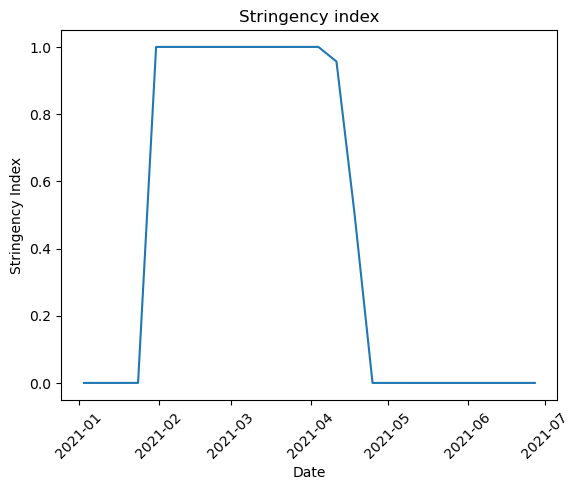

In [13]:
plot_si(df_young)

Middle-aged

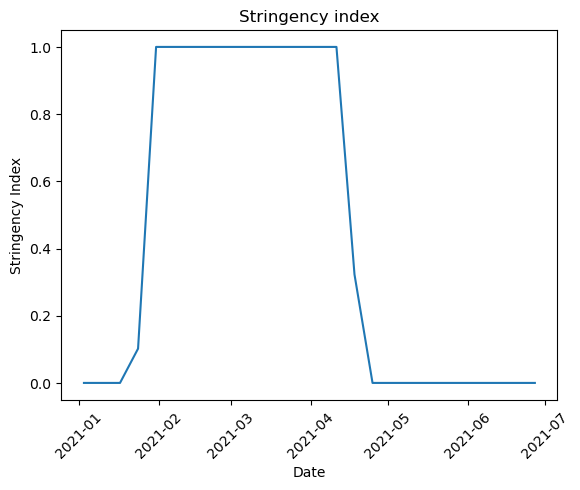

In [14]:
plot_si(df_middle)

Old

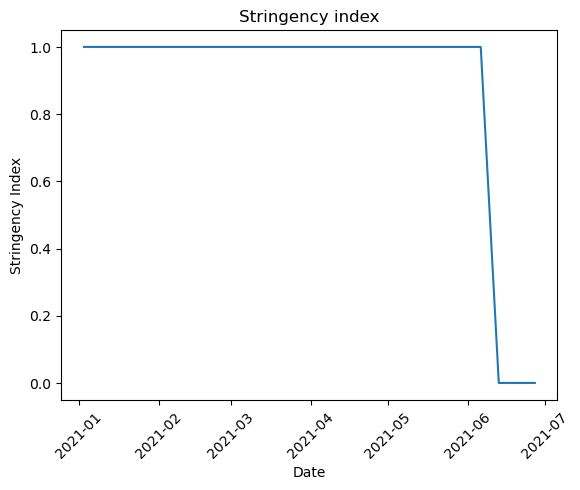

In [15]:
plot_si(df_old)

### Recursive predictions

In [16]:
npis = [
    "C1M",
    "C2M",
    "C3M",
    "C4M",
    "C5M",
    "C6M",
    "C7M",
    "C8M",
    "H1"
]

npi_labels = [
    "School closing",
    "Workplace closing",
    "Cancel public events",
    "Restrictions on gatherings",
    "Close public transport",
    "Stay at home requirements",
    "Restrictions on internal movement",
    "International travel controls",
    "Public information campaigns"
]

In [17]:
mtl_model = load_model("./models/mtl_model_all.h5")
num_tasks = 9
num_features = num_tasks + 1

In [18]:
def iterative_predict(init, indexes):
    f = lambda x: np.argmax(x, axis=-1)
    iterative_predictions = []

    for j in range(0, len(indexes)):
        predictions = mtl_model.predict(
            x=init.reshape(-1, num_features),
            batch_size=10,
            verbose=0)
        predictions = np.array(predictions)
        predictions = f(predictions)
        init = np.concatenate(([indexes[j]], predictions.flatten()))
        iterative_predictions.append(predictions.flatten())

    return list(zip(*iterative_predictions))

In [19]:
def step_plot(xlabel, ylabel, xvalue, yvalue, title, spacing,):
    fig, ax = plt.subplots()
    ax.step(xvalue, yvalue)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)  # Adjust the rotation angle as needed
    plt.show()

In [20]:
def plot_predictions(df_age):
    init = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

    indexes = df_age['Si'].tolist()
    indexes_no_first = indexes[1:]
    long_term_predictions = iterative_predict(init=init, indexes=indexes_no_first)

    for i in range(0, 9):
        step_plot(xlabel='Date', ylabel=npis[i], xvalue=df_age.index[1:],
                  yvalue= long_term_predictions[i], title=npi_labels[i], spacing=20)

Young

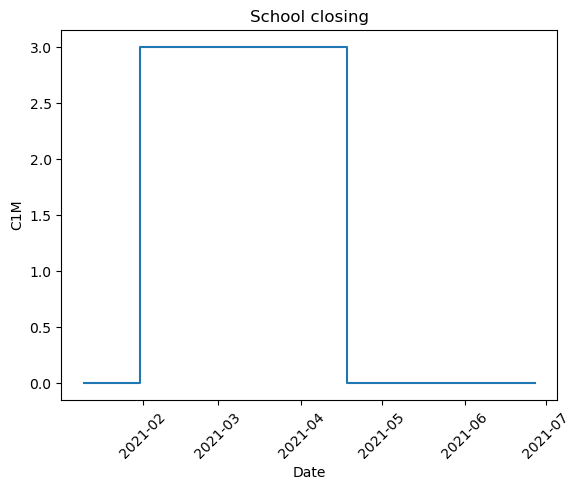

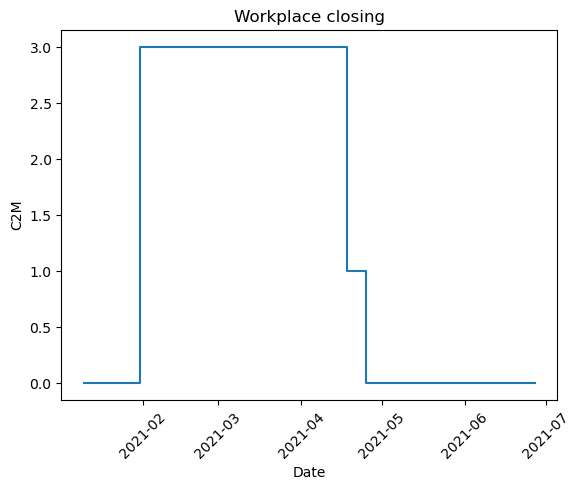

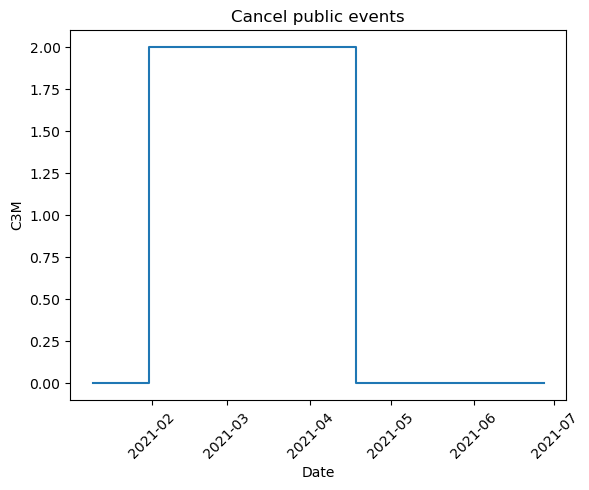

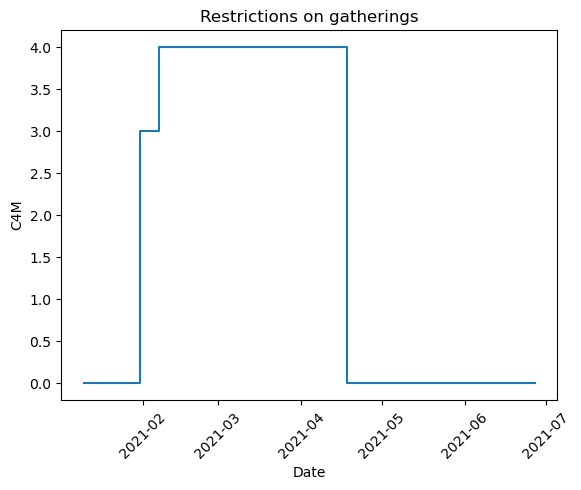

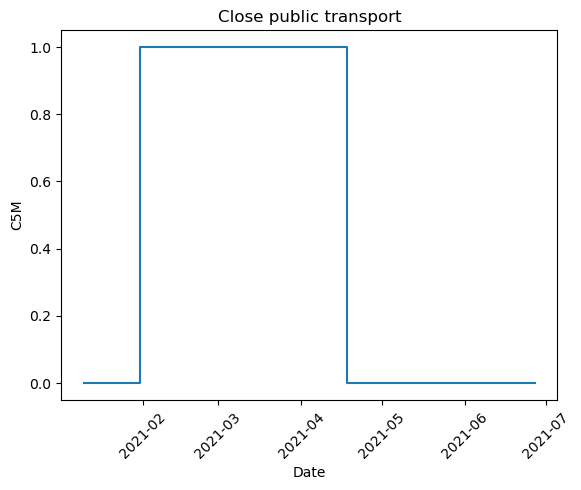

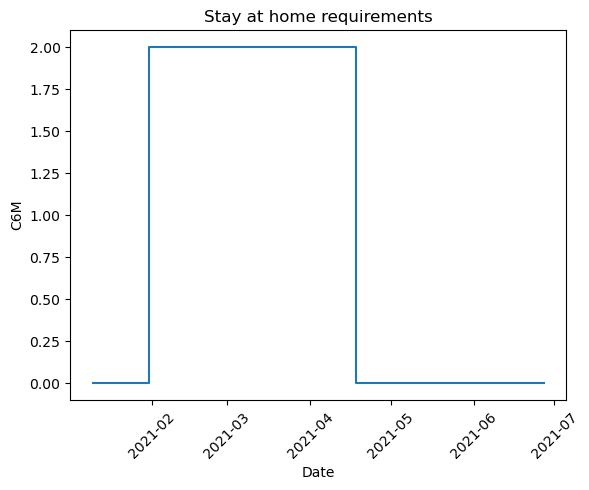

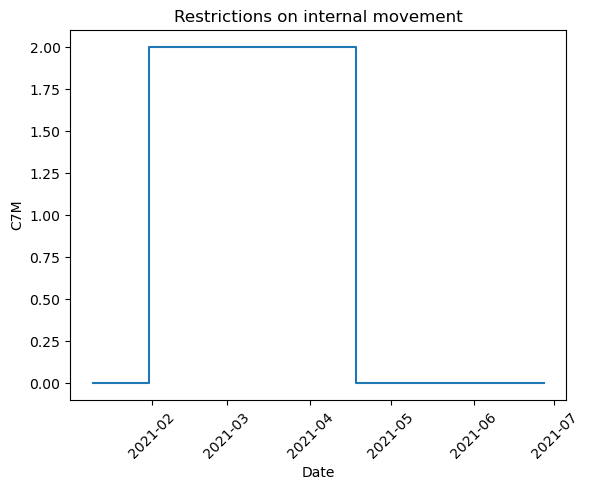

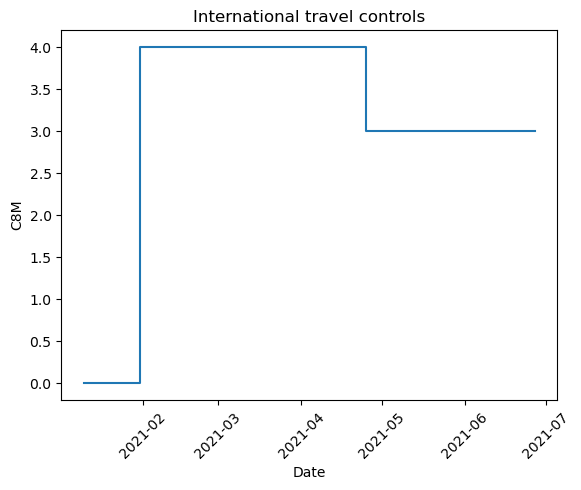

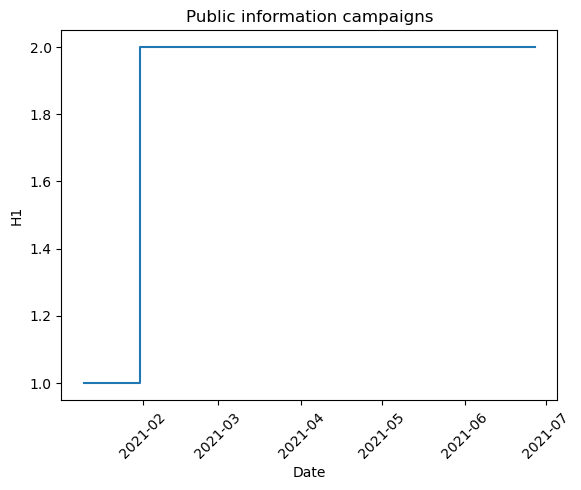

In [21]:
plot_predictions(df_young)

Middle-aged

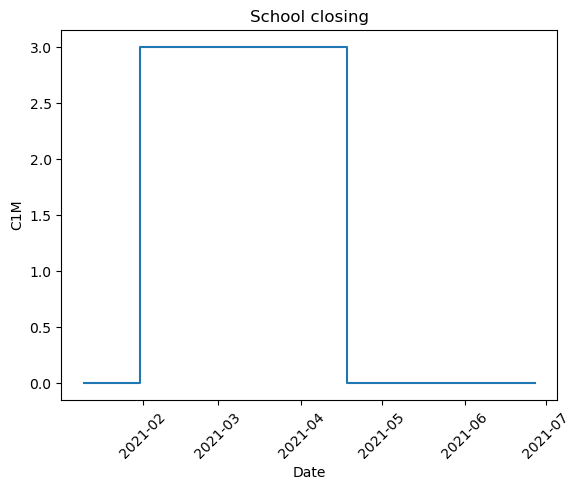

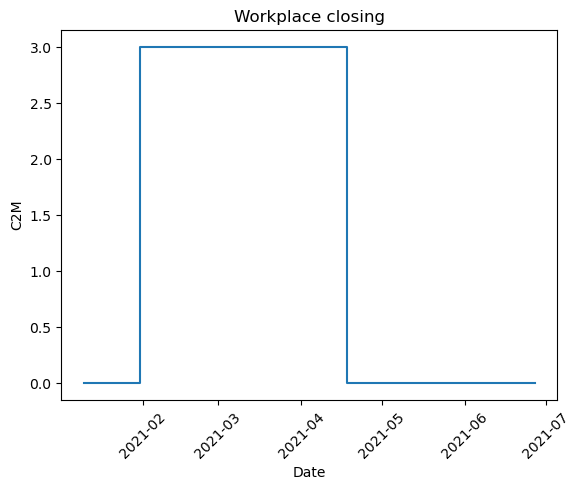

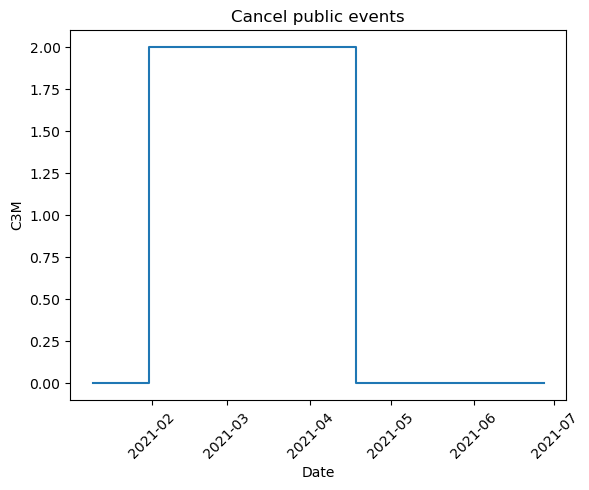

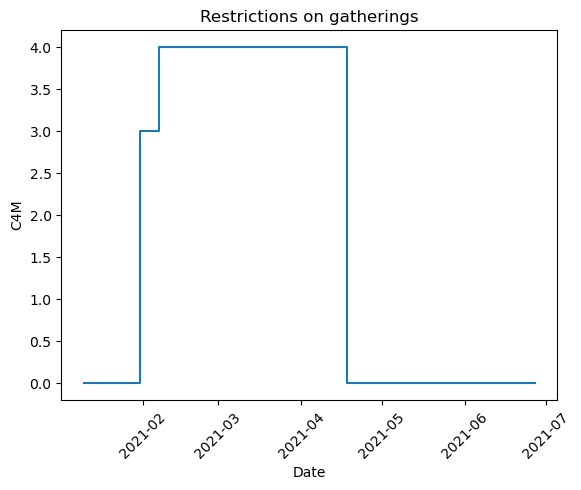

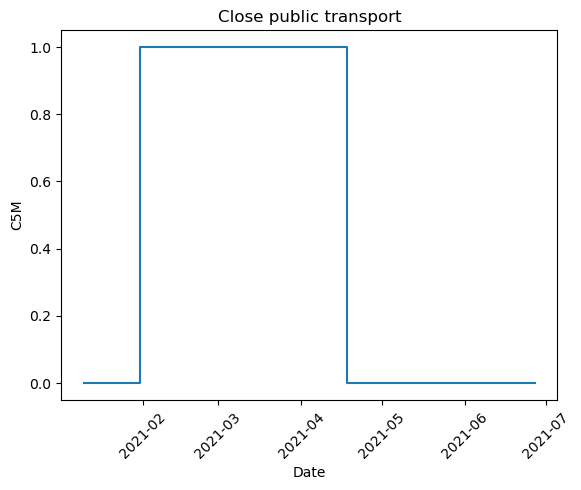

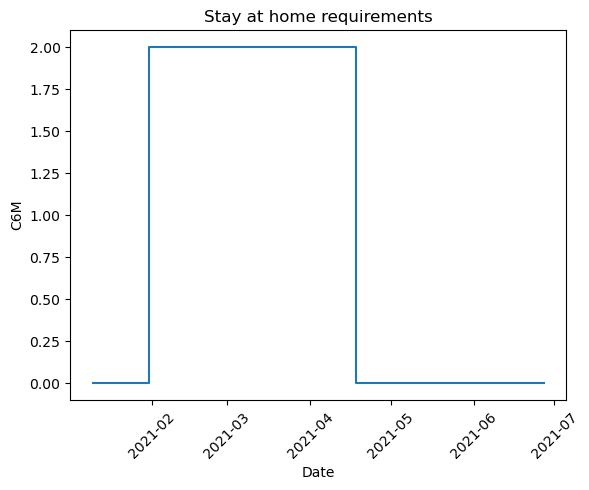

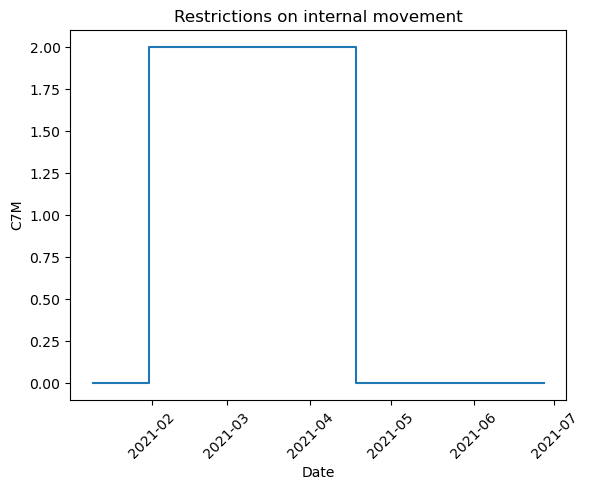

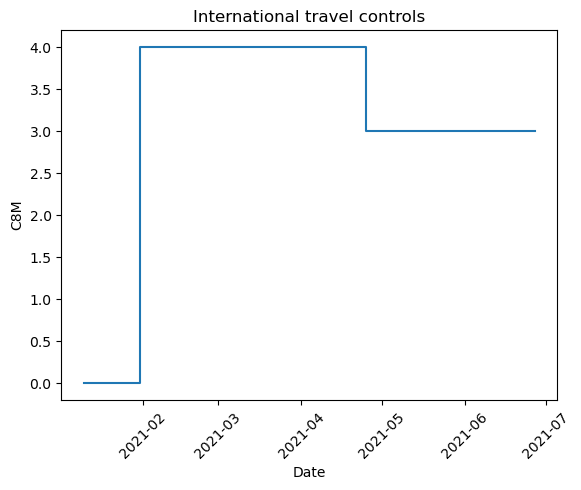

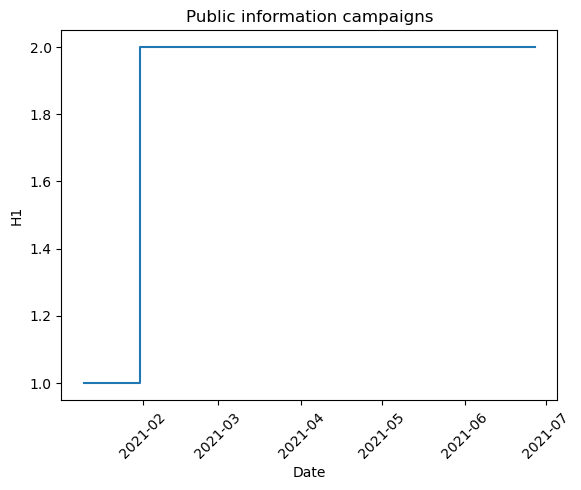

In [22]:
plot_predictions(df_middle)

Old

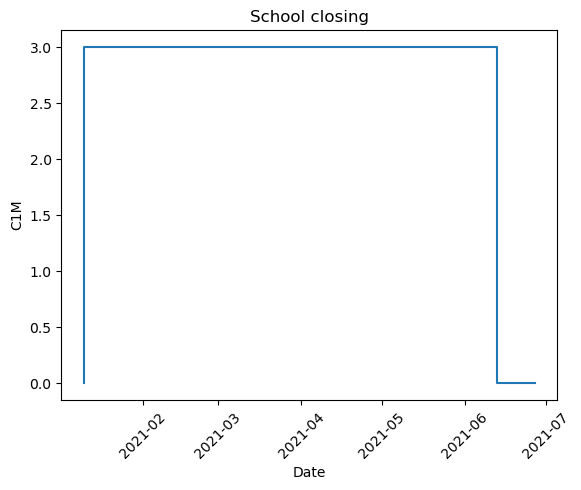

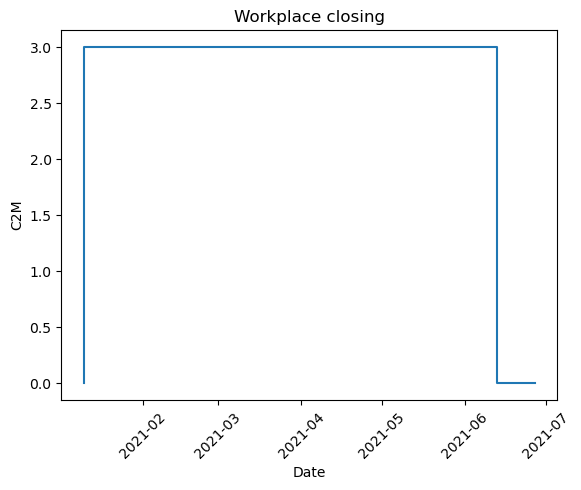

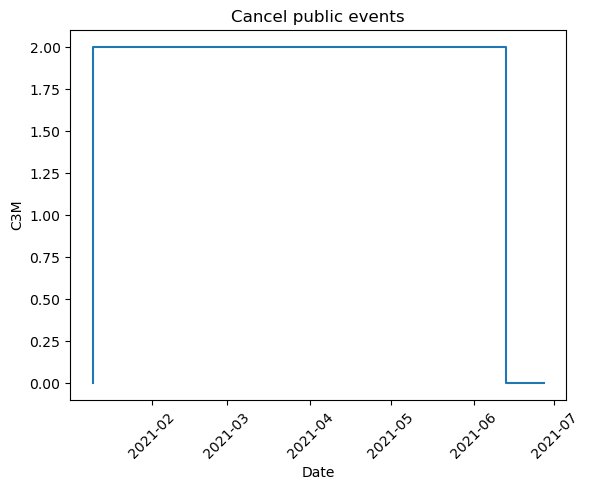

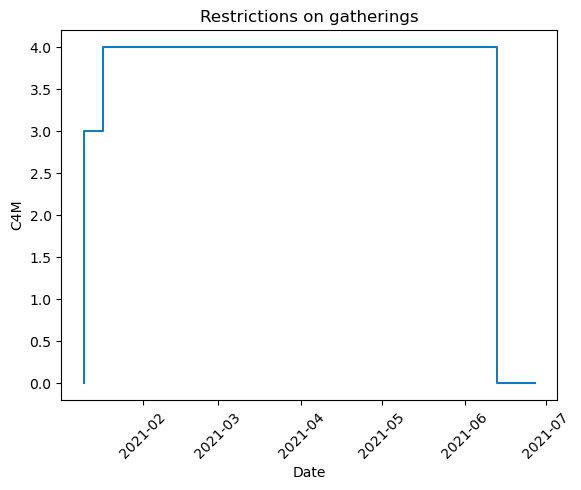

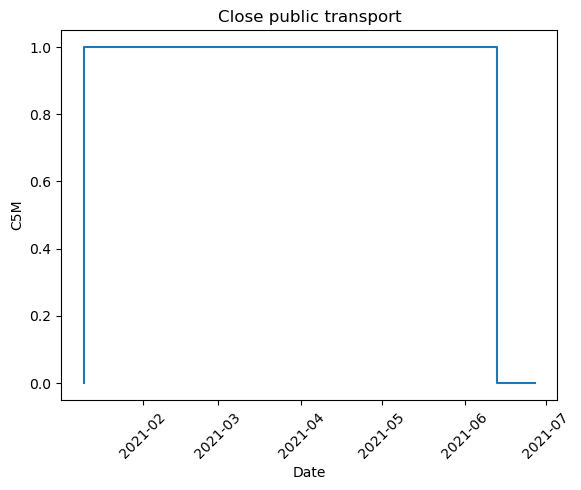

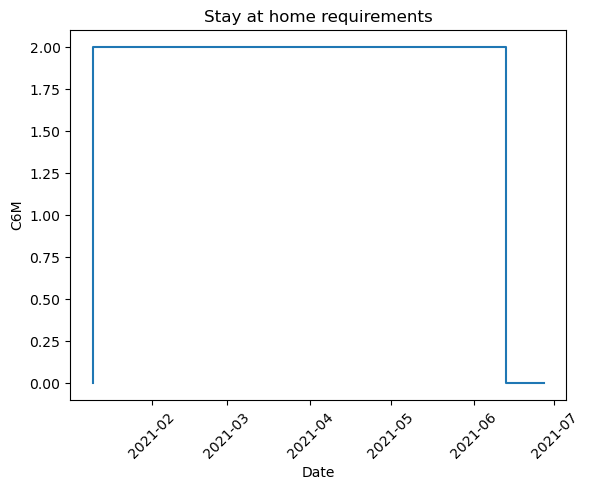

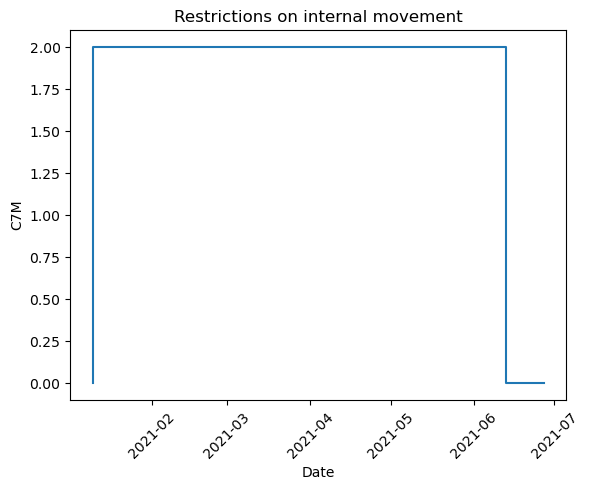

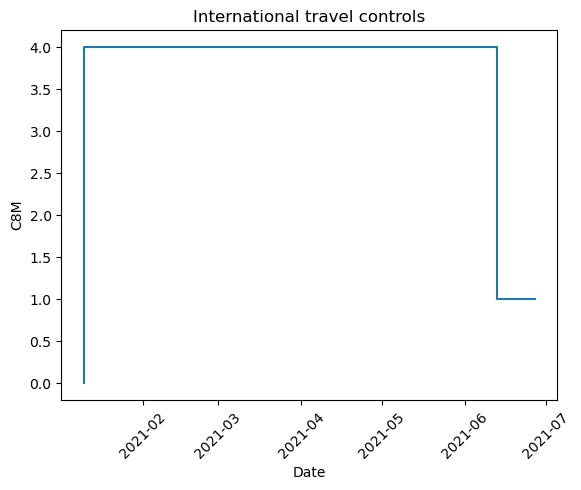

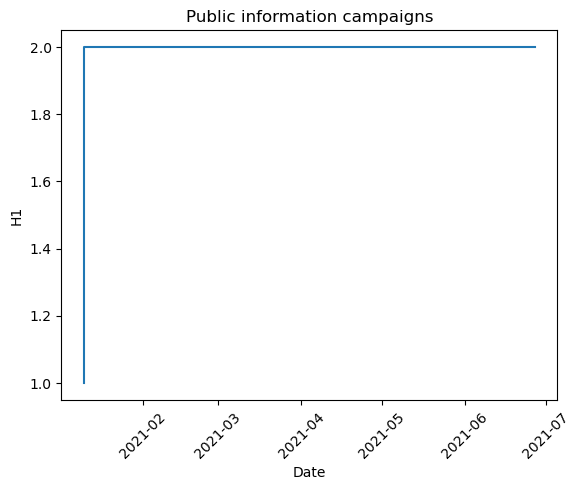

In [23]:
plot_predictions(df_old)